In [9]:

import json
import os
import numpy as np
import matplotlib.pyplot as plt

def process_json(json_file, target_length=1000, isi_dict='energy'):
    """
    Membaca data dari file JSON dan memastikan semua nilai bertipe float atau np.nan.
    - Jika nilai None di JSON, diganti dengan np.nan.
    - Jika nilai lebih sedikit dari target_length, sisanya diisi dengan np.nan.
    - Jika lebih banyak, dipotong (slice) sesuai target_length.
    """
    if os.path.exists(json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)
        data = data[isi_dict]
        # Buat dict dengan key int(episode) dan value float (atau np.nan)
        processed_data = {}
        for k, v in data.items():
            episode_index = int(k)
            if v is None:
                processed_data[episode_index] = np.nan
            else:
                # Pastikan bisa dikonversi ke float
                processed_data[episode_index] = float(v)
        
        # Urutkan berdasarkan episode, lalu ambil nilainya
        sorted_keys = sorted(processed_data.keys())
        sorted_values = [processed_data[k] for k in sorted_keys]

        # Potong/isi agar panjang data sesuai target_length
        adjusted_data = sorted_values[:target_length]
        if len(adjusted_data) < target_length:
            adjusted_data += [np.nan] * (target_length - len(adjusted_data))
        
        return adjusted_data
    else:
        print(f"[Warning] File {json_file} tidak ditemukan. Mengembalikan array np.nan.")
        return [np.nan] * target_length

def rolling_stats(data, window_size=10):
    """
    Menghitung rolling average dan rolling standard deviation untuk data.
    - Abaikan np.nan (tidak ikut dihitung).
    - Hasilnya berupa list yang sama panjang dengan data asli.
    """
    avg_list = []
    std_list = []

    for i in range(len(data)):
        start_idx = max(0, i - window_size + 1)
        window = data[start_idx : i + 1]
        
        # Ambil nilai valid (bukan np.nan)
        valid_vals = [val for val in window if not np.isnan(val)]
        
        if len(valid_vals) > 0:
            mean_val = np.mean(valid_vals)
            std_val  = np.std(valid_vals)
        else:
            mean_val = np.nan
            std_val  = np.nan

        avg_list.append(mean_val)
        std_list.append(std_val)

    return avg_list, std_list

def plot_metrics_with_shadow(json_files, labels,
                             title, xlabel, ylabel,
                             x_tick_interval=50, y_tick_interval=50,
                             target_length=1000,
                             window_size=10,
                             y_min=-600, y_max=300
                             ):
    """
    Membuat plot dari beberapa file JSON:
    1. (Raw data TIDAK ditampilkan)
    2. Plot rolling average untuk setiap data.
    3. Tambahkan 'shadow' (fill_between) berdasarkan standard deviation.
    """
    plt.figure(figsize=(10, 8))

    # Rentang episode untuk sumbu x
    x_values = range(1, target_length+1)

    for json_file, label in zip(json_files, labels):
        # Ambil data (tidak kita plot raw-nya)
        data = process_json(json_file, target_length)
        
        # Hitung rolling average & std
        avg_list, std_list = rolling_stats(data, window_size=window_size)

        # Plot garis rolling average
        (line,) = plt.plot(x_values, avg_list, label=f"{label}", linewidth=2)

        # Siapkan batas atas dan bawah untuk area shadow
        upper_bound = []
        lower_bound = []
        for m, s in zip(avg_list, std_list):
            if not np.isnan(m) and not np.isnan(s):
                upper_bound.append(m + s)
                lower_bound.append(m - s)
            else:
                upper_bound.append(np.nan)
                lower_bound.append(np.nan)

        # Fill area di sekitar rolling average (shadow)
        plt.fill_between(
            x_values,
            lower_bound,
            upper_bound,
            color=line.get_color(),
            alpha=0.2
        )

    # Konfigurasi sumbu X
    plt.xticks(
        range(0, target_length + 1, x_tick_interval),
        fontsize=12,
        rotation=45
    )

    # Konfigurasi sumbu Y
    plt.yticks(
        np.arange(y_min, y_max + 1, y_tick_interval),
        fontsize=12
    )
    plt.ylim(y_min, y_max)

    # Judul, Label, dan Legenda
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlim(1,1000)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=12, loc='lower left')
    plt.grid(True, alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.show()

def compute_json_average(json_file, target_length=1000):
    """
    Menghitung rata-rata dari data yang dihasilkan oleh process_json untuk file JSON yang diberikan.
    Nilai np.nan diabaikan dalam perhitungan.
    """
    data = process_json(json_file, target_length)
    # Hitung rata-rata dengan mengabaikan nilai np.nan
    avg = np.int32(np.ceil(np.nanmean(data)))
    print()

    return avg

def plot_bar_averages(json_files, labels, target_length=1000, title='Rata-rata',xlabel='Episode', ylabel='Rata-rata'):
    """
    Menghitung rata-rata untuk setiap file JSON yang diberikan dan menampilkan grafik bar plot.
    Nilai rata-rata ditampilkan di atas setiap bar.
    """
    averages = []
    for json_file in json_files:
        avg = compute_json_average(json_file, target_length)
        averages.append(avg)
    
    # Buat grafik bar plot
    plt.figure(figsize=(16, 10))
    x_positions = np.arange(len(labels))
    bars = plt.bar(x_positions, averages, color='skyblue')
    
    # Tambahkan nilai di atas setiap bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2, height, f'{int(height)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold'
        )
    
    plt.xticks(x_positions, labels, fontsize=12)
    plt.ylabel(ylabel, fontsize=14)
    plt.title('Rata-rata '+title, fontsize=16)
    plt.grid(axis='y', alpha=0.75)
    plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_boxplots(json_files, labels, target_length=1000,
                                  title='Boxplot', xlabel='Model', ylabel='Makespan'):
    """
    Menampilkan boxplot dan mencetak (dibulatkan ke atas):
    - Persentase outlier
    - Nilai min
    - Nilai max
    - Rata-rata
    untuk setiap seri data.
    """
    data_list = []

    for json_file, label in zip(json_files, labels):
        data = process_json(json_file, target_length)
        valid_data = np.array([v for v in data if not np.isnan(v)])
        data_list.append(valid_data)

        # Hitung kuartil & IQR
        q1 = np.percentile(valid_data, 25)
        q3 = np.percentile(valid_data, 75)
        iqr = q3 - q1

        # Tentukan fences untuk outlier
        lower_fence = q1 - 1.5 * iqr
        upper_fence = q3 + 1.5 * iqr

        # Hitung jumlah outlier dan persentasenya
        n_out = np.sum((valid_data < lower_fence) | (valid_data > upper_fence))
        pct_out = 100 * n_out / len(valid_data)

        # Hitung min, max, rata-rata
        #print("valid_data", len(valid_data))
        data_min  = valid_data.min()
        data_max  = valid_data.max()
        data_mean = valid_data.mean()

        # Bulatkan ke atas
        pct_out_ceil  = pct_out
        min_ceil      = math.ceil(data_min)
        max_ceil      = math.ceil(data_max)
        mean_ceil     = math.ceil(data_mean)

        # Cetak hasil
        print(f"{label}:")
        print(f"  Outlier   : {pct_out_ceil}%")
        print(f"  Min / Max : {min_ceil} / {max_ceil}")
        print(f"  Mean      : {mean_ceil}")
        print()

    # Plot boxplot
    plt.figure(figsize=(16, 10))
    plt.boxplot(data_list, labels=labels, patch_artist=True)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', alpha=0.75)
    plt.show()


In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np

def compute_success_rate(json_file, target_length=1000, threshold=1.2):
    """
    Menghitung success rate berdasarkan dua kriteria:
      1) field 'success' == 1
      2) rasio energy/makespan <= threshold

    Asumsi:
      - process_json(..., isi_dict='success') hanya mengembalikan 0 atau 1.
      - len(data_success) == len(data_makespan) == len(data_energy).
    """
    # Ambil data dari JSON (tanpa cast karena success sudah 0/1)
    data_success  = process_json(json_file, target_length=target_length, isi_dict='success')
    data_makespan = [float(x) for x in process_json(json_file, target_length=target_length, isi_dict='makespan')]
    data_energy   = [float(x) for x in process_json(json_file, target_length=target_length, isi_dict='energy')]

    # Potong jika lebih panjang dari target_length
    data_success  = data_success[:target_length]
    data_makespan = data_makespan[:target_length]
    data_energy   = data_energy[:target_length]
    # Hitung jumlah data (asumsi sama panjang == target_length)
    N = len(data_success)

    # Hitung sukses
    success_count = 0
    for suc, m, e in zip(data_success, data_makespan, data_energy):
        # cuma hitung jika success==1 dan rasio <= threshold
        if suc == 1 and m > 0 and (e / m) <= threshold:
            success_count += 1

    # Return dalam persen, basis N (bukan selalu target_length)
    return success_count / N * 100

def plot_bar_success_rates(json_files, labels, target_length=1000, threshold=1.2):
    """
    Menampilkan bar plot success rate untuk setiap file JSON.
    Success rate dihitung sebagai persentase nilai == 1.
    """
    success_rates = []
    for json_file in json_files:
        rate = compute_success_rate(json_file, target_length, threshold=threshold)
        success_rates.append(rate)
    
    # Buat grafik bar plot
    plt.figure(figsize=(16, 6))
    x_positions = np.arange(len(labels))
    bars = plt.bar(x_positions, success_rates, color='lightgreen')
    
    # Tambahkan nilai di atas setiap bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold'
        )
    
    plt.xticks(x_positions, labels, fontsize=12)
    plt.ylabel('Success Rate (%)', fontsize=14)
    plt.title('Success rate penyelesain 21 produk\ndengan waktu di bawah 250 step, kapasitas maksimum konveyor 80%, dan  daya tidak lebih dari 1.2 unit/step', fontsize=16)
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

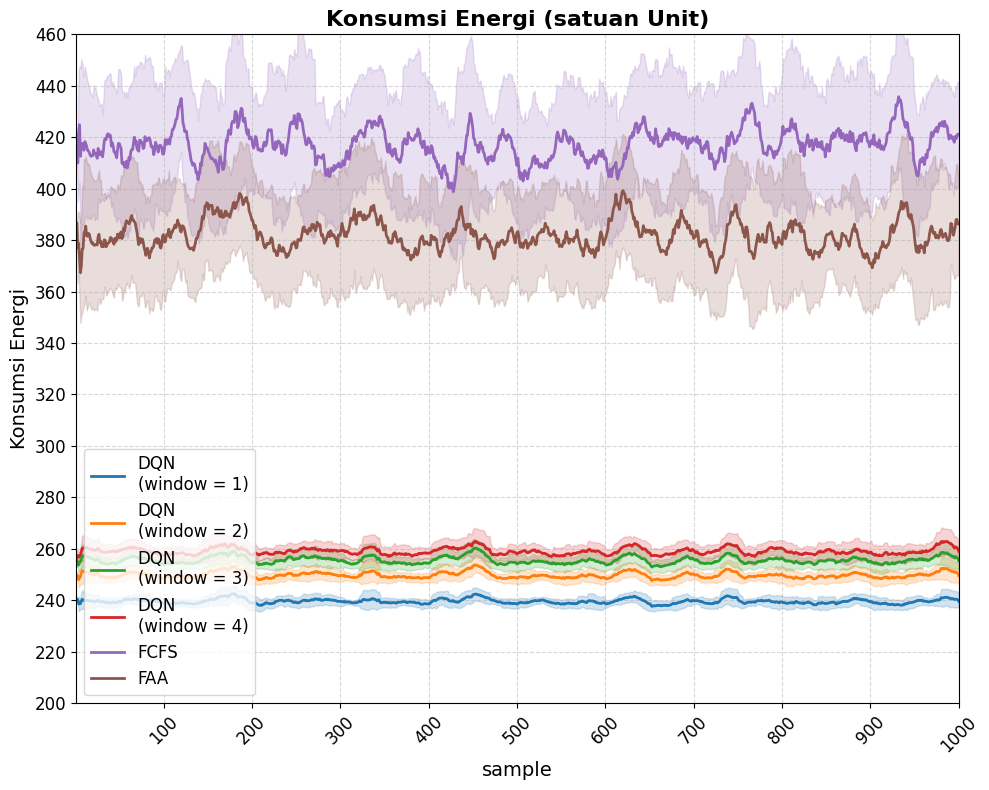

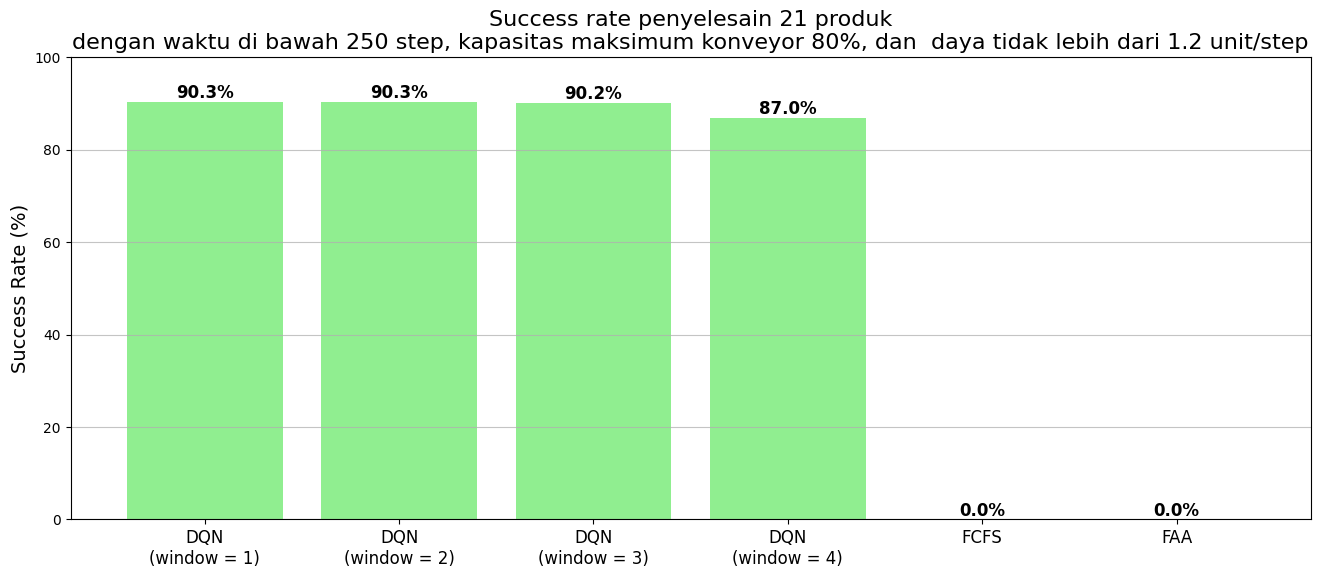

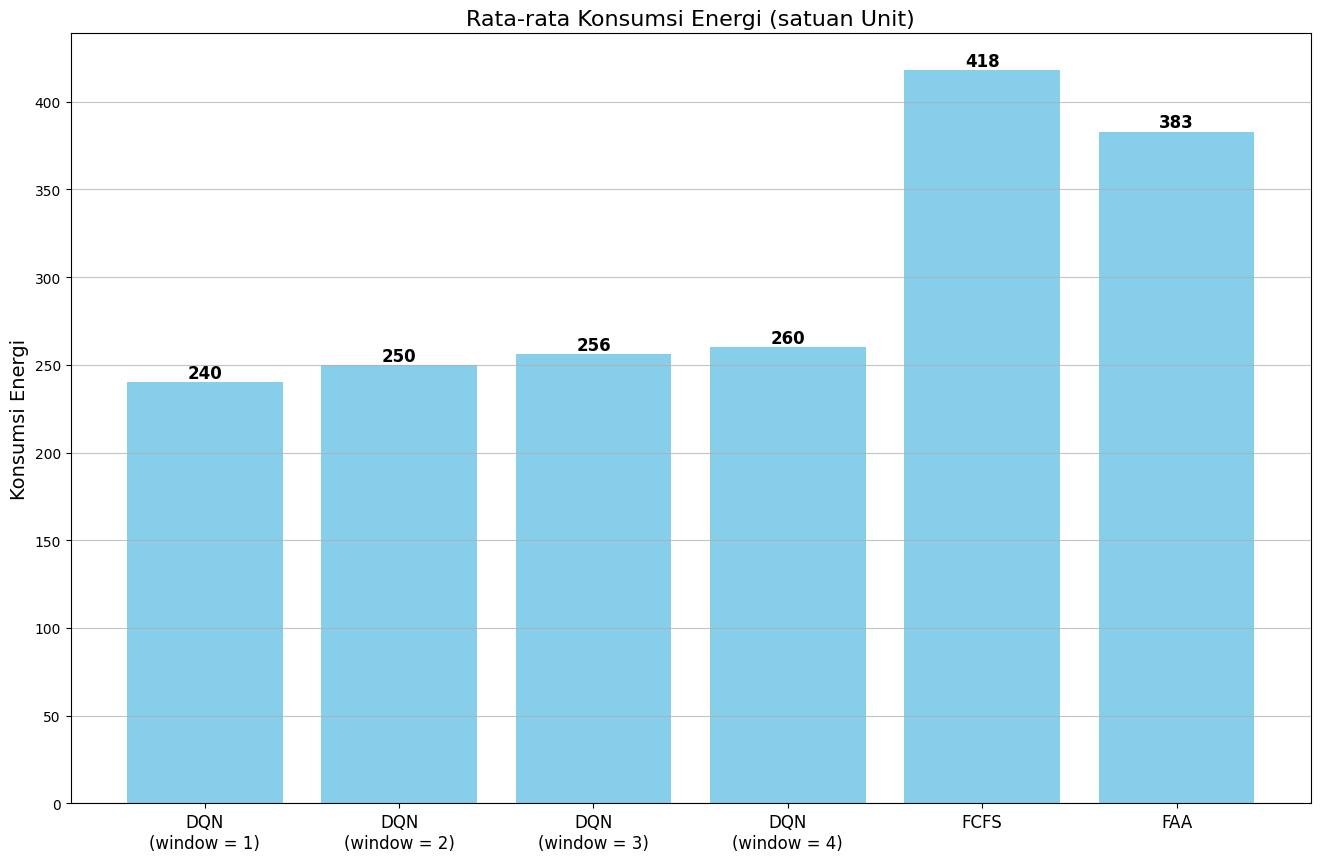

DQN
(window = 1):
  Outlier   : 2.5%
  Min / Max : 233 / 252
  Mean      : 240

DQN
(window = 2):
  Outlier   : 3.5%
  Min / Max : 243 / 266
  Mean      : 250

DQN
(window = 3):
  Outlier   : 3.5%
  Min / Max : 249 / 272
  Mean      : 256

DQN
(window = 4):
  Outlier   : 1.8%
  Min / Max : 251 / 277
  Mean      : 260

FCFS:
  Outlier   : 0.3%
  Min / Max : 351 / 526
  Mean      : 418

FAA:
  Outlier   : 0.8%
  Min / Max : 307 / 458
  Mean      : 383



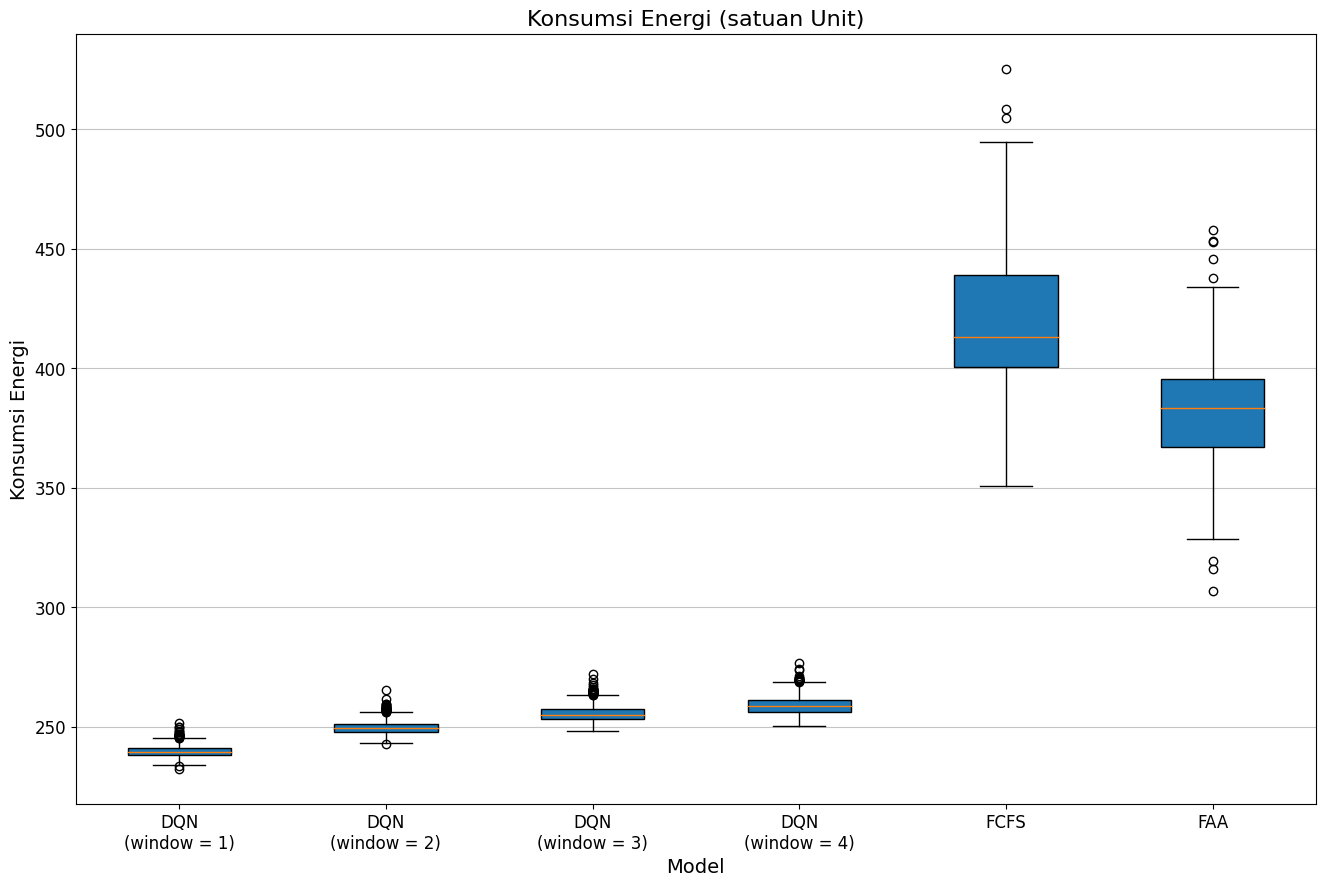

In [12]:

yr0_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\4_FJSP_unconstrained\\tanpawait'
yr1_v2_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\4_FJSP_unconstrained\\yr1_v2'
yr2_v2_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\4_FJSP_unconstrained\\yr2_v2'
yr3_v2_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\4_FJSP_unconstrained\\yr3_v2'
ruled_based_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\4_FJSP_unconstrained\\ruled_based_model'


# FCFS=os.path.join(env_dir, '3_Ruled_Based')
# without_noise_diskrit=os.path.join(env_dir, '3_Ruled_Based')

files = [
    os.path.join(yr0_dir, 'Testing_DQN_yr0_1000ep_600_80max.json'),
    os.path.join(yr1_v2_dir, 'Testing_DQN_yr1_1000ep_600_80max.json'),
    os.path.join(yr2_v2_dir, 'Testing_DQN_yr2_1000ep_600_80max.json'),
    os.path.join(yr3_v2_dir, 'Testing_DQN_yr3_1000ep_600_80max.json'),
    os.path.join(ruled_based_dir, 'Testing_FCFS_1000ep_80.json'),
    os.path.join(ruled_based_dir, 'Testing_FAA_1000ep_80.json'),
]
labels = [
    'DQN\n(window = 1)',
    'DQN\n(window = 2)',
    'DQN\n(window = 3)',
    'DQN\n(window = 4)',
    'FCFS',
    'FAA',
]
target_length = 1000
title='Konsumsi Energi (satuan Unit)'
xlabel='Model'
ylabel='Konsumsi Energi'
# Panggil fungsi plot
plot_metrics_with_shadow(
    json_files=files,
    labels=labels,
    title=title,
    xlabel='sample',
    ylabel=ylabel,
    x_tick_interval=100,
    y_tick_interval=20,
    target_length=target_length,  # Sesuaikan jika perlu panjang data berbeda
    window_size=20,      # Lebar jendela rolling average/std
    y_min=200,
    y_max=460,
)
plot_bar_success_rates(json_files=files, labels=labels, target_length=target_length, threshold=1.2) 
plot_bar_averages(json_files=files, labels=labels, target_length=target_length, title=title, xlabel=xlabel, ylabel=ylabel) 
plot_boxplots(json_files=files, labels=labels, target_length=target_length, title=title, xlabel=xlabel, ylabel=ylabel)